In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time

import matplotlib.ticker as mticker



In [2]:
def get_stablecoin_data():
    # List of major stablecoins
    stablecoins = {
        'pyusd': 'paypal-usd',
        'usdc': 'usd-coin',
        'usdt': 'tether'
    }

    # Base URL for CoinGecko API
    base_url = "https://api.coingecko.com/api/v3"

    all_data = []

    for display_name, coin_id in stablecoins.items():
        # Get market data
        url = f"{base_url}/coins/{coin_id}/market_chart?vs_currency=usd&days=365&interval=daily"

        try:
            response = requests.get(url)
            data = response.json()

            # Extract prices and timestamps
            prices = data['prices']
            volumes = data['total_volumes']
            market_caps = data['market_caps']

            # Convert to DataFrame
            df_price = pd.DataFrame(prices, columns=['timestamp', 'price'])
            df_volume = pd.DataFrame(volumes, columns=['timestamp', 'volume'])
            df_market_cap = pd.DataFrame(market_caps, columns=['timestamp', 'market_cap'])

            # Combine metrics
            df = df_price.merge(df_volume, on='timestamp')
            df = df.merge(df_market_cap, on='timestamp')

            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df['coin'] = display_name

            all_data.append(df)

            # Sleep to respect rate limits
            time.sleep(1)

        except Exception as e:
            print(f"Error fetching data for {display_name}: {e}")

    # Combine all data
    combined_df = pd.concat(all_data, ignore_index=True)

    return combined_df

def analyze_stability(df):
    # Calculate basic statistics
    stats = df.groupby('coin').agg({
        'price': ['mean', 'std', 'min', 'max'],
        'volume': 'mean',
        'market_cap': 'mean'
    })

    # Calculate volatility
    stats[('price', 'volatility')] = stats[('price', 'std')] / stats[('price', 'mean')]

    # Rename columns for clarity
    stats.columns = ['price_mean', 'price_std', 'price_min', 'price_max',
                    'avg_daily_volume', 'avg_market_cap', 'price_volatility']

    return stats






In [3]:
    print("Fetching stablecoin data...")
    df = get_stablecoin_data()

    # Analyze stability
    print("\nStability Analysis:")
    stats = analyze_stability(df)
    print(stats)

  # Save data to CSV
    print("\nSave data to CSV...")
   
 
    df.to_csv('stablecoin_data.csv', index=False)
    stats.to_csv('stablecoin_stats.csv')





Fetching stablecoin data...

Stability Analysis:
       price_mean  price_std  price_min  price_max  avg_daily_volume  \
coin                                                                   
pyusd    0.999530   0.001218   0.995481   1.005999      2.448074e+07   
usdc     0.999978   0.000620   0.997406   1.003413      7.699856e+09   
usdt     0.999947   0.000801   0.997259   1.002570      6.009353e+10   

       avg_market_cap  price_volatility  
coin                                     
pyusd    4.960819e+08          0.001219  
usdc     3.632432e+10          0.000620  
usdt     1.186756e+11          0.000801  

Generating analysis plots...


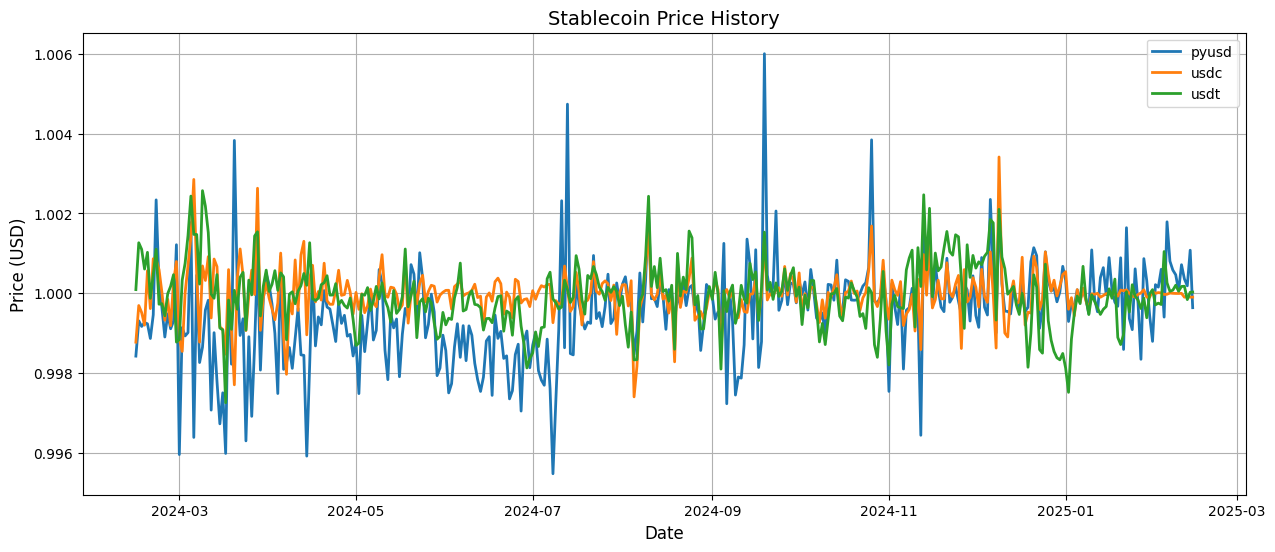

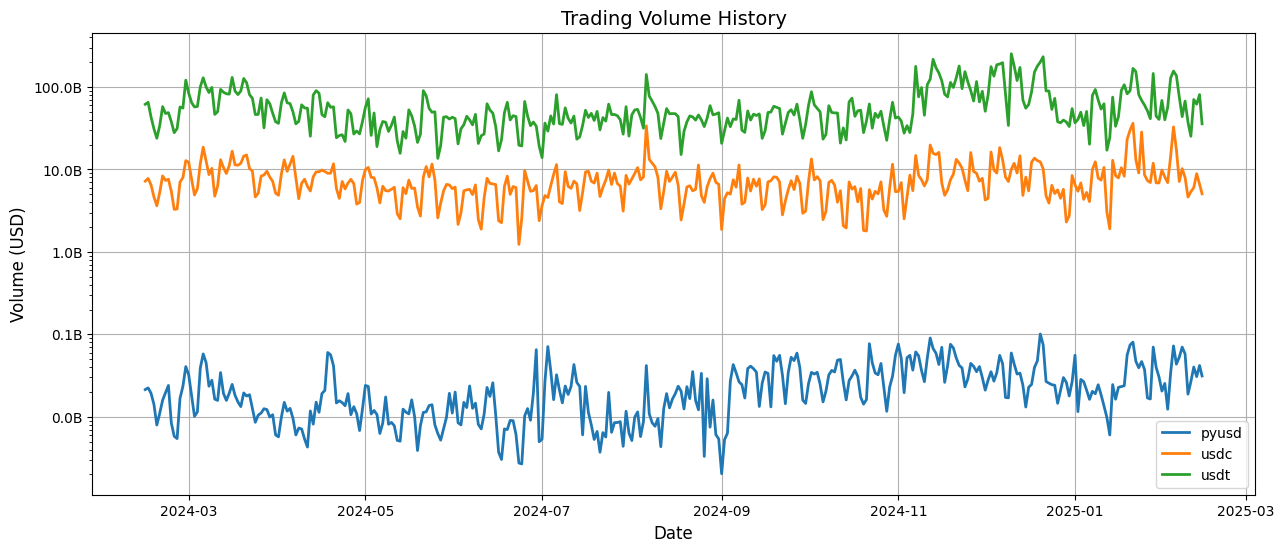

In [10]:
def billions_formatter(x, pos):
    return f'{x / 1e9:.1f}B'
formatter = mticker.FuncFormatter(billions_formatter)


# Price History Plot
plt.figure(figsize=(15, 6))
for coin in df['coin'].unique():
    coin_data = df[df['coin'] == coin]
    plt.plot(coin_data['timestamp'], coin_data['price'], label=coin, linewidth=2)
plt.title('Stablecoin Price History', fontsize=14)
plt.ylabel('Price (USD)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

# Volume History Plot
plt.figure(figsize=(15, 6))
for coin in df['coin'].unique():
    coin_data = df[df['coin'] == coin]
    plt.plot(coin_data['timestamp'], coin_data['volume'], label=coin, linewidth=2)
plt.title('Trading Volume History', fontsize=14)
plt.ylabel('Volume (USD)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.yscale('log')  # Using log scale for better volume visualization
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()



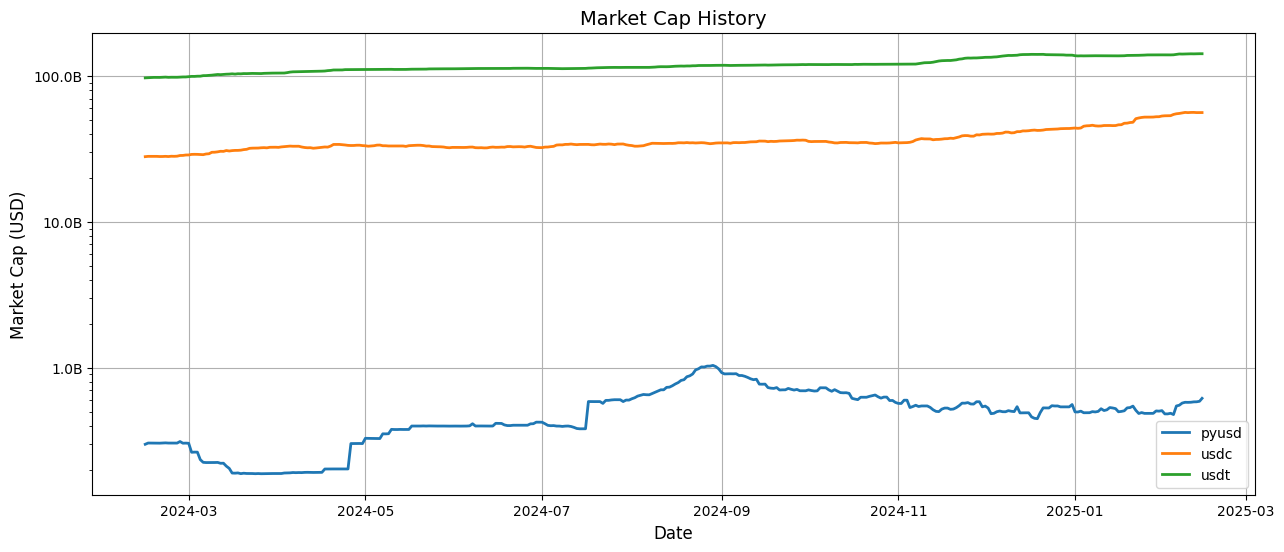

In [9]:
# Market Cap History Plot
plt.figure(figsize=(15, 6))
for coin in df['coin'].unique():
    coin_data = df[df['coin'] == coin]
    plt.plot(coin_data['timestamp'], coin_data['market_cap'], label=coin, linewidth=2)
plt.title('Market Cap History', fontsize=14)
plt.ylabel('Market Cap (USD)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.yscale('log')  # Using log scale for better market cap visualization
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()